<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E10-TwitterNetworkAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Network Analysis
This notebook contains a social network analysis mainly executed with the library of NetworkX. In detail, this dataset consists of 'circles' (or 'lists') from Twitter. Twitter data was crawled from public sources. The dataset includes node features (profiles), circles, and ego networks. The dataset can be found at this link: [Stanford Twitter Dataset](https://snap.stanford.edu/data/ego-Twitter.html).

## Import packages

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import networkx.algorithms.community as nx_comm

%matplotlib inline

## Analysis
The edges are loaded from the `data` folder and saved in a dataframe. Each edge is a new row and for each edge there is a `start_node` and an `end_node` column

In [2]:
twitter = pd.read_csv(
    "https://snap.stanford.edu/data/twitter_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
twitter = twitter.iloc[:80000]

The graph is created from the `twitter` dataframe of the edges:

In [3]:
G = nx.from_pandas_edgelist(twitter, "start_node", "end_node")

## Visualizing the graph

Let's start our exploration by visualizing the graph. Visualization plays a
central role in exploratory data analysis to help get a qualitative feel for
the data.

Since we don't have any real sense of structure in the data, let's start by
viewing the graph with `random_layout`, which is among the fastest of the layout
functions.

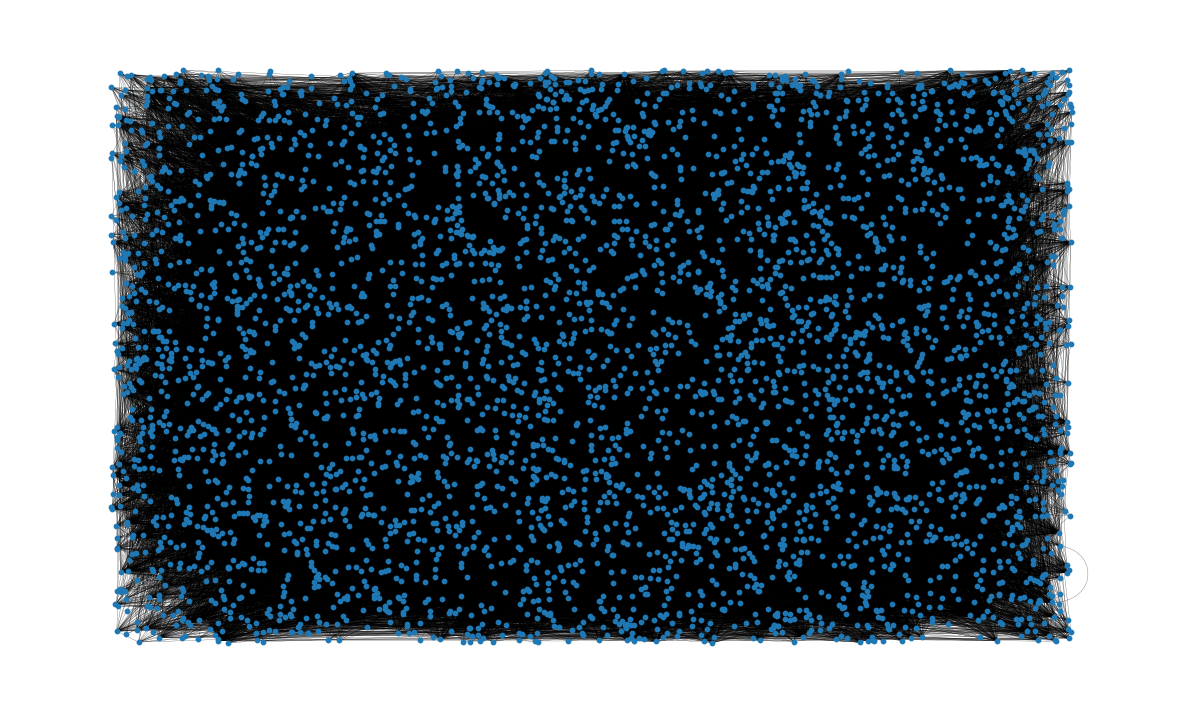

In [4]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Do we need more or less information (nodes or edges) from the graph to do the analysis? Let's check `spring_layout` and continue analysis...

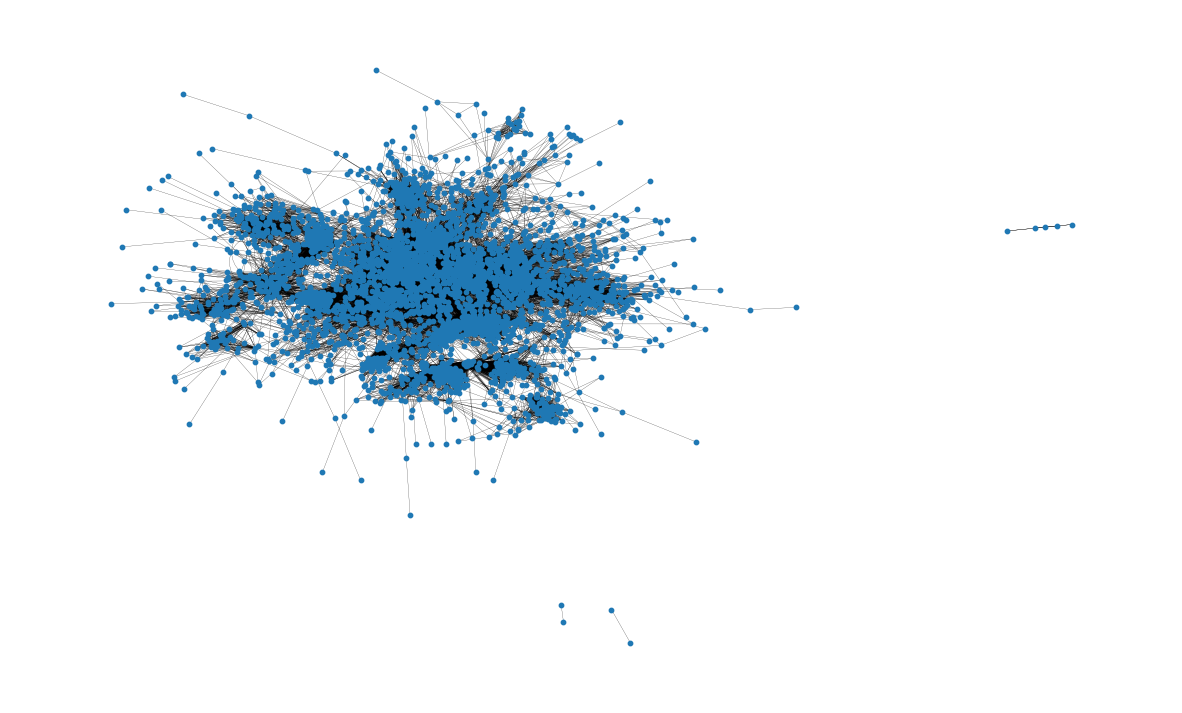

In [5]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

What other information can we extract from this network? ... (check graphs metrics)

# **Atributos Básicos**

### Número de Nodos

In [6]:
#Número de Nodos del Grafo de Twitter
G.number_of_nodes()

4316

### Número de Vértices

In [7]:
#Número de vértices del grafo de Twitter
G.number_of_edges()

58270

### Promedio de Grados de los Nodos

In [8]:
np.mean([d for _, d in G.degree()])

27.00185356811863

En promedio, los nodos del grafo de Twitter contienen alrededor de 27 grados. Esto significa que cada nodo tienen promedio esta cantidad de conexiones con otros nodos del grafo (usuarios y seguidores)

### Número de componentes

In [9]:
nx.number_connected_components(G)

7

El grafo de Twitter contiene 7 componentes principales. Esto significa que hay 7 'Subgrafos' con mayor conexión entre sí, lo que facilita las interacciones entre los 4316 usuarios. Mayor número de componentes haría que las interacciones o influencias dentro de la red no fueran tan fuertes

# **Métricas de Integración**

### Caminos más cortos

In [10]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [11]:
print(shortest_path_lengths.keys()) # identificar las claves del set

dict_keys([214328887, 34428380, 17116707, 28465635, 380580781, 18996905, 221036078, 153460275, 107830991, 17868918, 151338729, 222261763, 19705747, 88323281, 19933035, 149538028, 158419434, 17434613, 153226312, 364971269, 100581193, 279787626, 113058991, 69592091, 187773078, 406628822, 262802533, 460282402, 280935165, 437804658, 27633075, 285312927, 131613362, 17675120, 394263193, 254839786, 204317520, 21548772, 67864340, 172883064, 270449528, 297801196, 8088112, 14925700, 124528830, 307458983, 160237722, 220368467, 54228724, 206923844, 103598216, 207594668, 21146135, 451250774, 314316607, 6581292, 31331740, 196327549, 225444667, 274153775, 35415466, 72818790, 324201646, 40981798, 430268163, 88097807, 276308596, 358775055, 15023872, 16870853, 70492333, 430313102, 299715516, 35359596, 276577539, 248883350, 157829215, 107511013, 22462180, 258140947, 200559228, 19493072, 123371682, 461410856, 31414569, 37699718, 117901353, 117674417, 231238695, 56860418, 43003845, 413275344, 259842341, 40

In [12]:
# Se toman dos nodos al azar para verificar el camino mas corto
shortest_path_lengths[214328887][221036078]

1

In [13]:
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# promedio de los valores de camino más corto
np.mean(average_path_lengths)

4.837700405033223

En promedio de todo el grafo, para que cada nodo pueda estar conectado con otro, existen alrededor de 4.8 nodos de distancia entre sí.

In [14]:
print(nx.is_connected(G))  # Verificar si el grafo está conectado

False


Dado que el grafo no está conectado completamente entre sí, se hará un análisis sobre uno de los componentes principales.

In [15]:
# Encontrar el componente más grande
largest_cc = max(nx.connected_components(G), key=len)
# Crear un subgrafo
G_largest = G.subgraph(largest_cc)

In [16]:
# Diámetro del subgrafo
diameter = max(nx.eccentricity(G_largest, sp=shortest_path_lengths).values())
print(diameter)

16


Lo anterior significa que para que cualquier nodo logre conectarse con otro, debería atravesar máximo 16 nodos de distancia.

Text(0, 0.5, 'Frecuencia (%)')

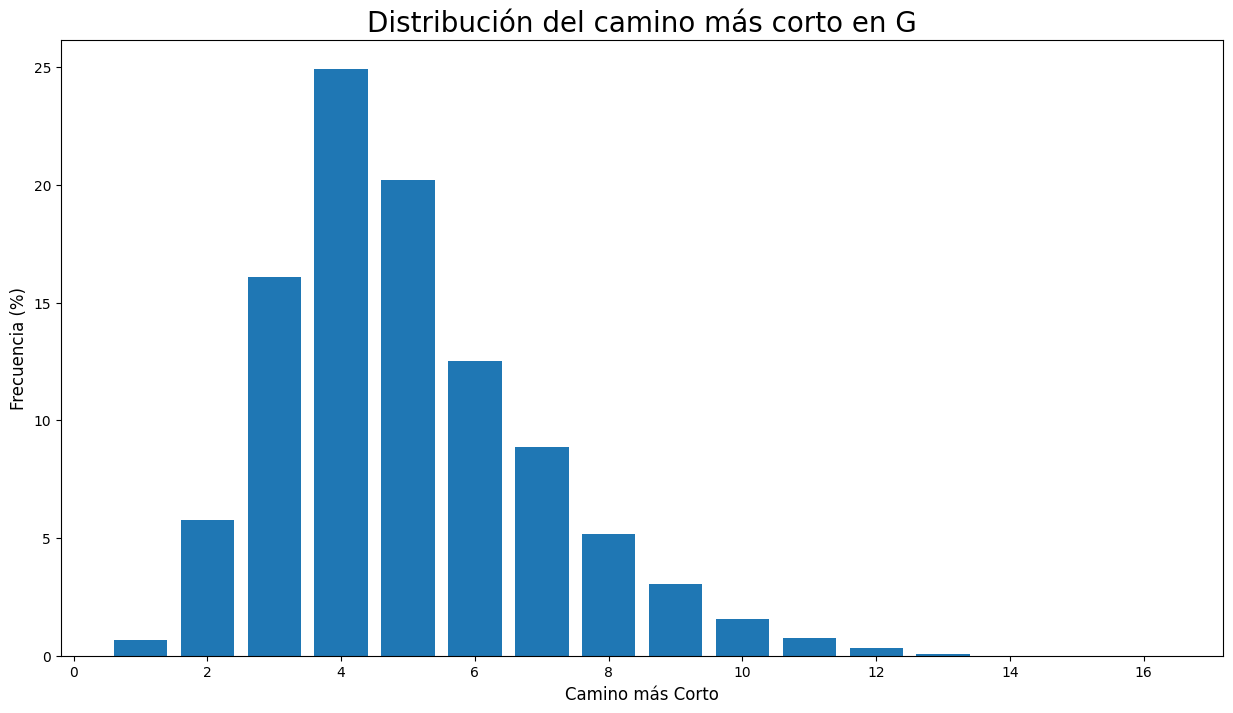

In [17]:
# Visualizar la distribución de los caminos mas cortos de todo el grafo
path_lengths = np.zeros(diameter + 1, dtype=int)

for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribución del camino más corto en G", fontdict={"size": 20}, loc="center"
)
ax.set_xlabel("Camino más Corto", fontdict={"size": 12})
ax.set_ylabel("Frecuencia (%)", fontdict={"size": 12})

Como se observa en la gráfica y según las métricas anteriores, la mayor distancia promedio entre nodos como camino mas corto se encuentra entre 2 y 8 nodos. De igual manera, para el subgrafo que es el componente mas grande, no hay caminos mayores a 16 nodos.

### Densidad

In [18]:
nx.density(G)

0.0062576717423218145

El resultado indica que, teniendo todas las métricas anteriores en cuenta, que la red tiene conexiones débiles e interacción menos frecuente (esto se puede ver en el promedio de grados del grafo). Esto implica que las interacciones realmente no se generan con facilidad y que un usuario (influenciador) no logrará generar influir significativamente en la porción mayoritaria de la red.

### Eficiencia

In [19]:
round(nx.global_efficiency(G),2)

0.22

Como complemento de la densidad, la eficiencia nos muestra que con un 0.22 de valor, que la red no tiene una conexión alta entre sí. La información no fluye con facilidad entre todos los nodos de la red.

### Puentes

In [20]:
nx.has_bridges(G)

True

In [21]:
bridges = list(nx.bridges(G))
len(bridges)

209

El grafo contiene 209 puentes en todo el grafo, es decir, vértices que si son eliminados, generan nuevos componentes.

In [22]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)

987

El grafo contiene 987 puentes locales, es decir, vértices que existen solo entre un par de nodos único. Sginifica que no estos nodos no tienen vecinos en común salvo sí mismos.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

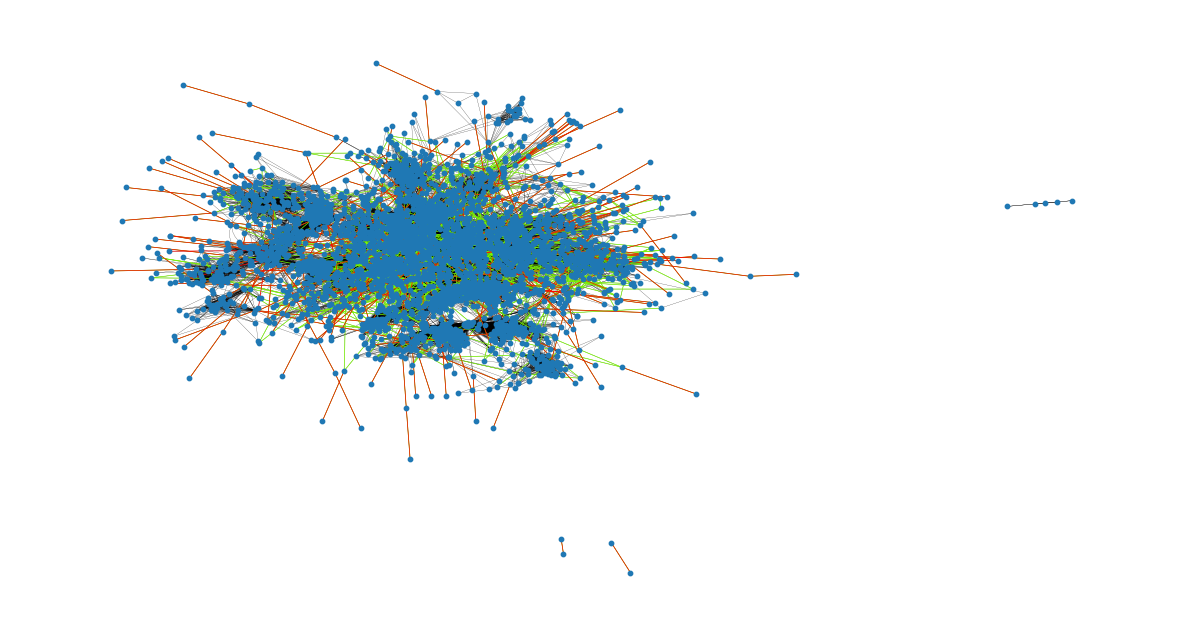

In [23]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

# **Métricas de Segregación**

### Clustering

In [24]:
nx.average_clustering(G)

0.4949716847236492

Text(0, 0.5, 'Conteo')

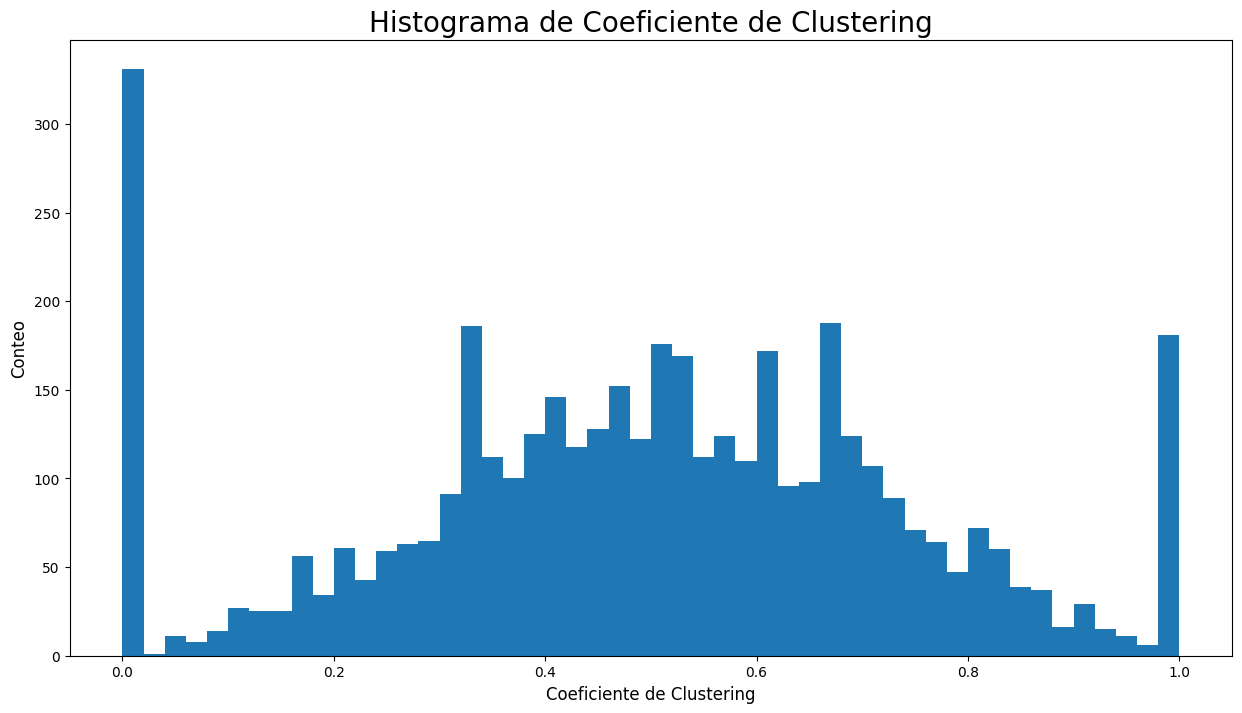

In [25]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Histograma de Coeficiente de Clustering", fontdict={"size": 20}, loc="center")
plt.xlabel("Coeficiente de Clustering", fontdict={"size": 12})
plt.ylabel("Conteo", fontdict={"size": 12})

A partir del histograma, podemos observar que la mayor proporción de los nodos del grafo de Twitter cuentan con un Coeficiente de Clustering entre los valores 0.3 y 0.7. El promedio se sitúa en 0.49.

Entre más alto sea el valor del coeficiente, mayor tendencia tendrá el nodo a formar agrupaciones. En este caso observamos que el grafo de Twitter no es completamente segregado, pero no es suficientemente conectado. Lo anterior ya se había visto con medidas anteriores.

Destaca que un número alto de nodos tienen un valor de coeficiente bajo, lo cual demuestra que en general las interacciones y uniones en este grafo no se dan sencillamente y hay tendencia a tener varios componentes.

In [26]:
# Número total de triángulos entre nodos del grafo
triangles_per_node = list(nx.triangles(G).values())
sum(triangles_per_node) / 3

465759.0

In [27]:
np.mean(triangles_per_node)

323.7435125115848

En promedio, un nodo de del grafo participa en al rededor de 323 triángulos.

In [28]:
np.median(triangles_per_node)

71.0

La media de triángulos en los que participa un nodo del grafo es de 71.

Lo anterior significa que hay nodos con altos valores de conexiones, sin embargo, al menos un 50% de los nodos no participa en mas de 71 triángulos.

De esta forma, podemos ver que la estructura de comunidades del grafo no es suficientemente fuerte para lograr conexiones entre todos los usuarios. En otras palabras, los usuarios no logran interactuar con facilidad con muchos de los usuarios del resto de Twitter.

### Transitividad

In [29]:
nx.transitivity(G)

0.4117694383246281

La transitividad tiene un valor de 0.41. Significa que dos nodos conectados entre sí tienen una probabilidad de 41% de generar una conexión con un tercer nodo.

### Comunidades de Redes

In [30]:
colors = {}
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)
    counter += 1
    for node in com:
        colors[node] = color
print(counter)

88


Se detectan 88 comunidades en la red, es decir, grupos de nodos que tienen conexiones mas fuerte entre sí que con nodos de otro grupo.

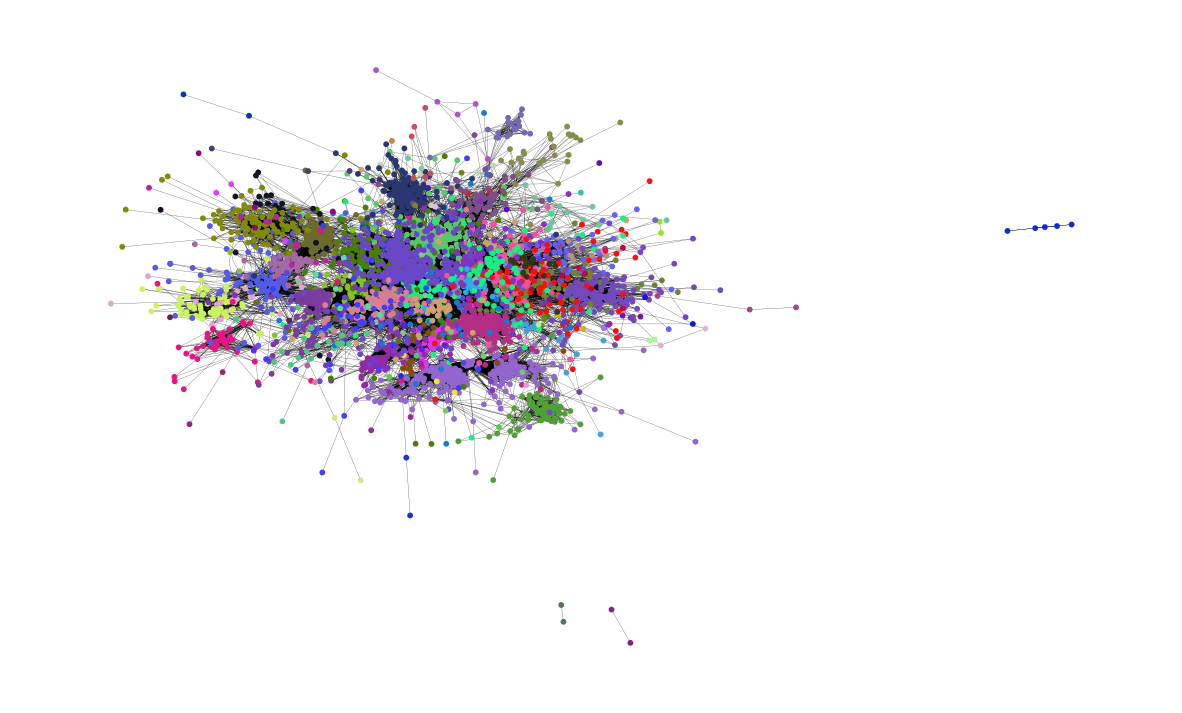

In [31]:
color_list = [colors[node] for node in G.nodes()]

plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=color_list
)

In [54]:
colors = {}  # Diccionario para almacenar el color de cada nodo en el subgrafo
for com in nx.community.asyn_fluidc(G_largest, 10, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Generar color aleatorio
    for node in com:
        colors[node] = color  # Asignar el color a cada nodo en el diccionario

Hacemos una énfasis en 10 comunidades para visualizarlas cada una con diferentes colores.

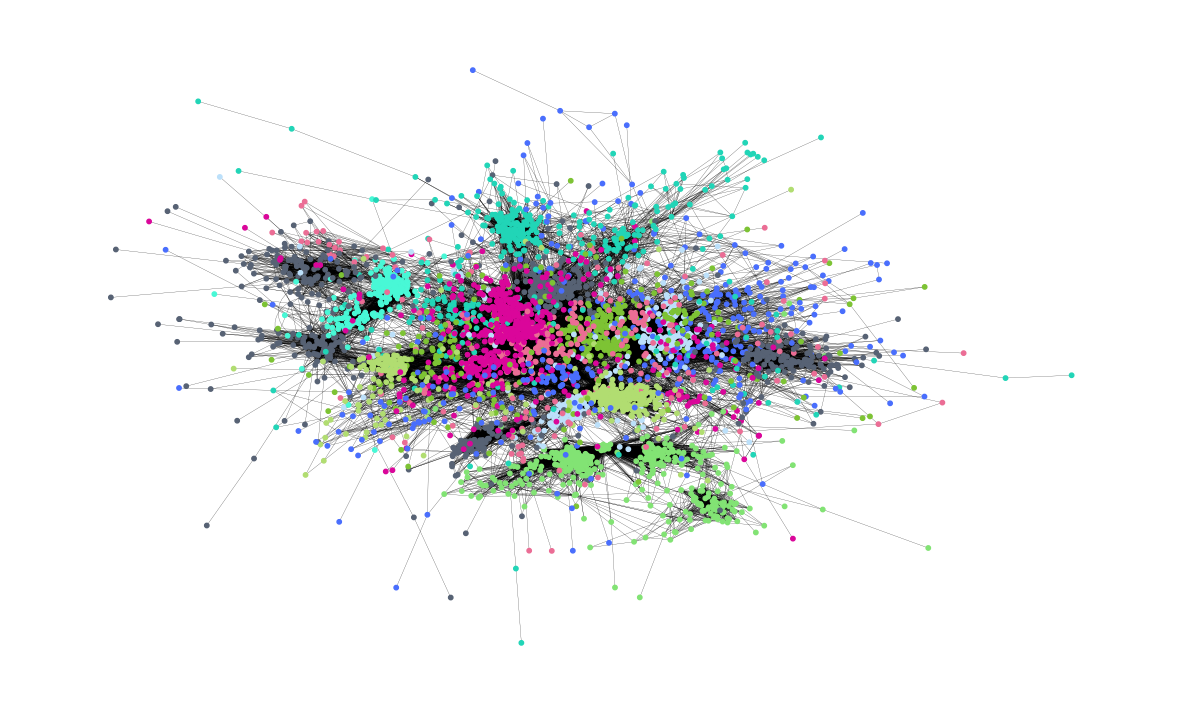

In [55]:
color_list = [colors[node] for node in G_largest.nodes()]

plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G_largest, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=color_list
)

### Modularidad

In [34]:
print(nx_comm.modularity(G, nx_comm.label_propagation_communities(G)))

0.8248668687208482


# **Métricas de Centralidad**

### Grados de Centralidad

In [35]:
nx.centrality.degree_centrality(G)

{214328887: 0.023174971031286212,
 34428380: 0.056315179606025494,
 17116707: 0.017149478563151795,
 28465635: 0.027578215527230592,
 380580781: 0.014600231749710313,
 18996905: 0.028041714947856317,
 221036078: 0.015063731170336037,
 153460275: 0.008111239860950173,
 107830991: 0.01993047508690614,
 17868918: 0.02618771726535342,
 151338729: 0.027346465816917728,
 222261763: 0.018308227114716108,
 19705747: 0.01205098493626883,
 88323281: 0.025724217844727695,
 19933035: 0.00996523754345307,
 149538028: 0.020162224797219002,
 158419434: 0.024797219003476246,
 17434613: 0.007184241019698725,
 153226312: 0.027809965237543453,
 364971269: 0.007879490150637311,
 100581193: 0.025028968713789106,
 279787626: 0.0287369640787949,
 113058991: 0.011587485515643106,
 69592091: 0.02294322132097335,
 187773078: 0.02526071842410197,
 406628822: 0.016917728852838935,
 262802533: 0.01205098493626883,
 460282402: 0.0050984936268829665,
 280935165: 0.01993047508690614,
 437804658: 0.008342989571263035,

In [36]:
degree_centrality = nx.centrality.degree_centrality(G)
#Top 5 nodos con máyor grado de centralidad
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:5]

[(48485771, 0.07022016222479723),
 (5442012, 0.06813441483198146),
 (3359851, 0.06581691772885284),
 (40981798, 0.06257242178447277),
 (43003845, 0.0593279258400927)]

Los siguientes son los principales nodos que generan agrupaciones o tienen mayor influencia en la red.

In [37]:
#Visualizar los vecinos de dichos nodos
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:5]

[(48485771, 303),
 (5442012, 294),
 (3359851, 284),
 (40981798, 270),
 (43003845, 256)]

Text(0, 0.5, 'Conteo')

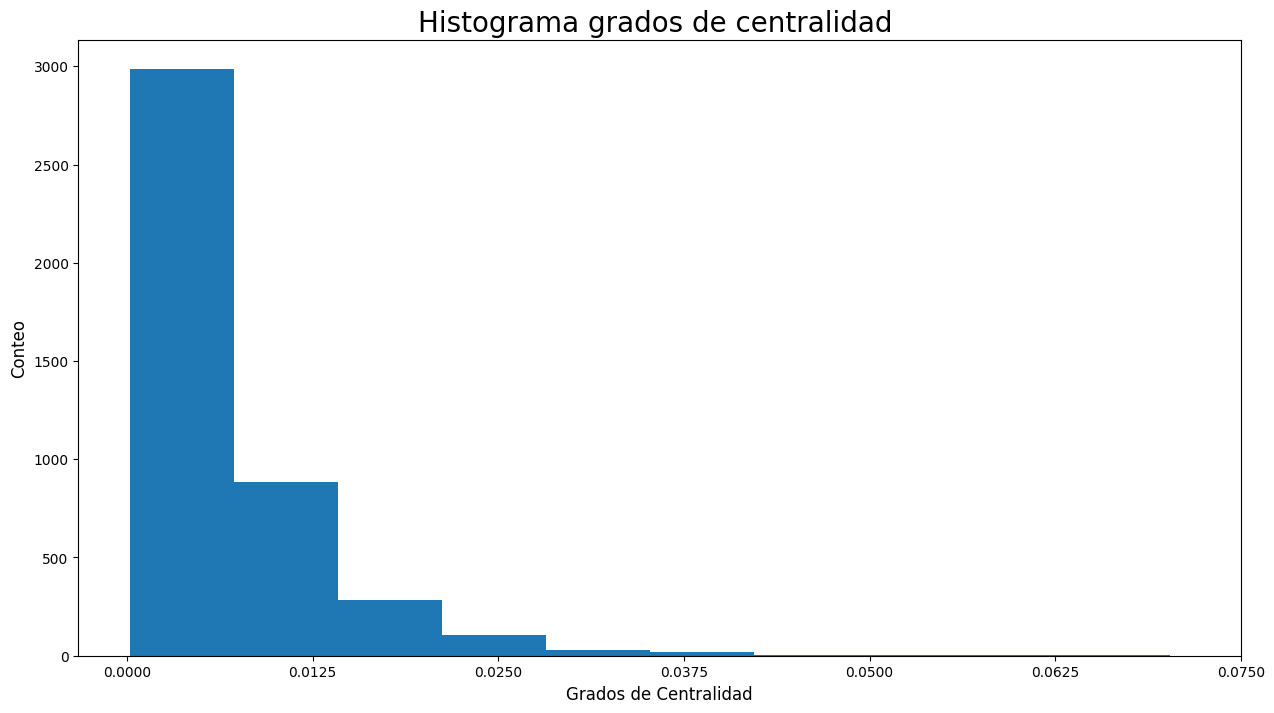

In [38]:
# Visulizar histograma de grados de centralidad
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=10)
plt.xticks(ticks=[0, 0.0125, 0.025, 0.0375, 0.05, 0.0625, 0.075])  # set the x axis ticks
plt.title("Histograma grados de centralidad ", fontdict={"size": 20}, loc="center")
plt.xlabel("Grados de Centralidad", fontdict={"size": 12})
plt.ylabel("Conteo", fontdict={"size": 12})

La mayor cantidad de nodos tienen un valor de centralidad menor a 0.0375. Efectivamente observamos que la mayoría de nodos no tienen una influencia alta sobre la red o sobre su capacidad de generar interacciones entre sí.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

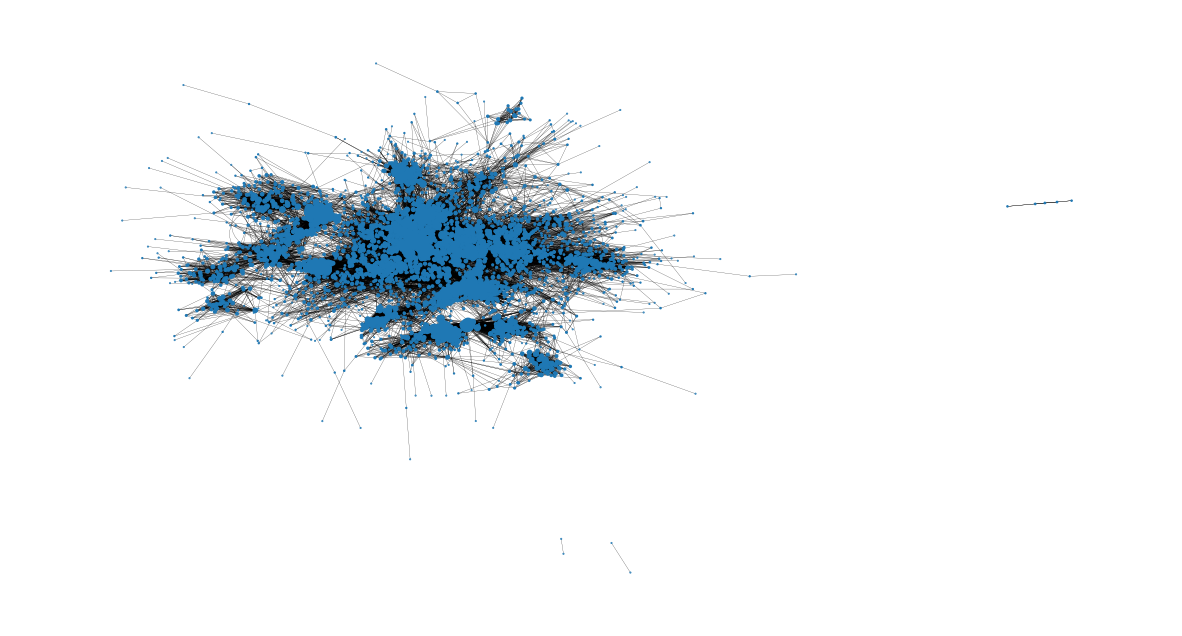

In [39]:
# Visualizar los nodos con mayor grado de centralidad
node_size = [v * 1000 for v in degree_centrality.values()]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de intermediación

In [40]:
nx.centrality.betweenness_centrality(G)

{214328887: 2.5082908314481238e-05,
 34428380: 0.021037197466361186,
 17116707: 6.971806170023784e-05,
 28465635: 0.0006583211358037852,
 380580781: 1.535309473005652e-06,
 18996905: 8.086118806320171e-05,
 221036078: 1.3483838335327062e-06,
 153460275: 4.180837210387545e-07,
 107830991: 4.688563902873442e-06,
 17868918: 5.98601870685985e-05,
 151338729: 6.077229298716775e-05,
 222261763: 5.605161318787643e-06,
 19705747: 0.0001280696304836396,
 88323281: 0.00011958831911943022,
 19933035: 2.2008440975508994e-05,
 149538028: 7.212386235859093e-06,
 158419434: 0.00014728504020676338,
 17434613: 0.00014750298457727842,
 153226312: 6.708732148285042e-05,
 364971269: 5.862132071628127e-06,
 100581193: 4.896410274620717e-05,
 279787626: 0.0007676081596227947,
 113058991: 7.134156181906071e-06,
 69592091: 2.2158881804864713e-05,
 187773078: 0.002265761724977153,
 406628822: 3.2803518743971713e-06,
 262802533: 6.532614317196061e-07,
 460282402: 5.091651663248e-07,
 280935165: 4.96469900507259

In [41]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)
#Top 5 nodos con máyor centralidad de intermediación
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:5]

[(6207392, 0.1725645640056724),
 (3359851, 0.15443758920551148),
 (783214, 0.0975291202117271),
 (41716273, 0.09272687817377762),
 (17093617, 0.09073724589851986)]

Text(0, 0.5, 'Conteo')

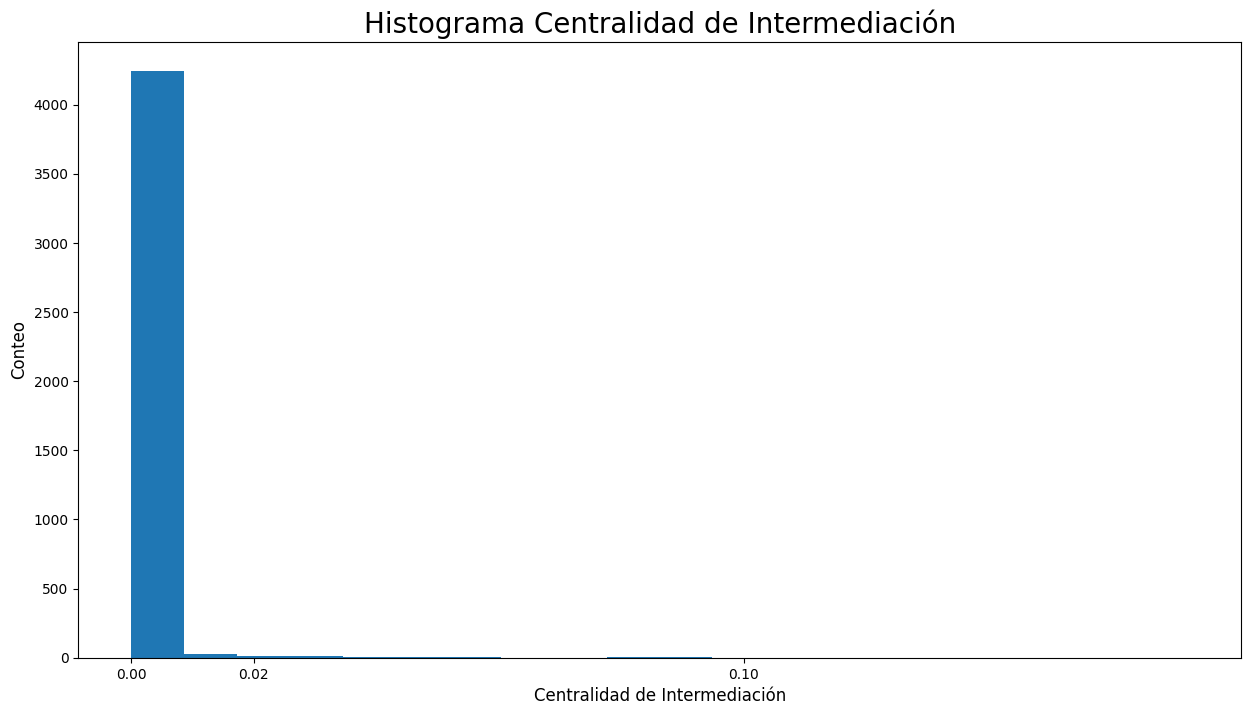

In [42]:
# Visulizar histograma de centralidad de intermediación
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=20)
plt.xticks(ticks=[0, 0.02, 0.1])
plt.title("Histograma Centralidad de Intermediación", fontdict={"size": 20}, loc="center")
plt.xlabel("Centralidad de Intermediación", fontdict={"size": 12})
plt.ylabel("Conteo", fontdict={"size": 12})

Solo dos nodos cuentan con un valor mayor de 0.1 de centralidad de intermediación. Esto significa que la mayoría de nodos no participan como puente en el camino mas corto entre todos los nodos del grafo. El top 5 identificado logra tener la mayor influencia sobre la red debido a que participan en la interacción de un número mayor de nodos y vecindades.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

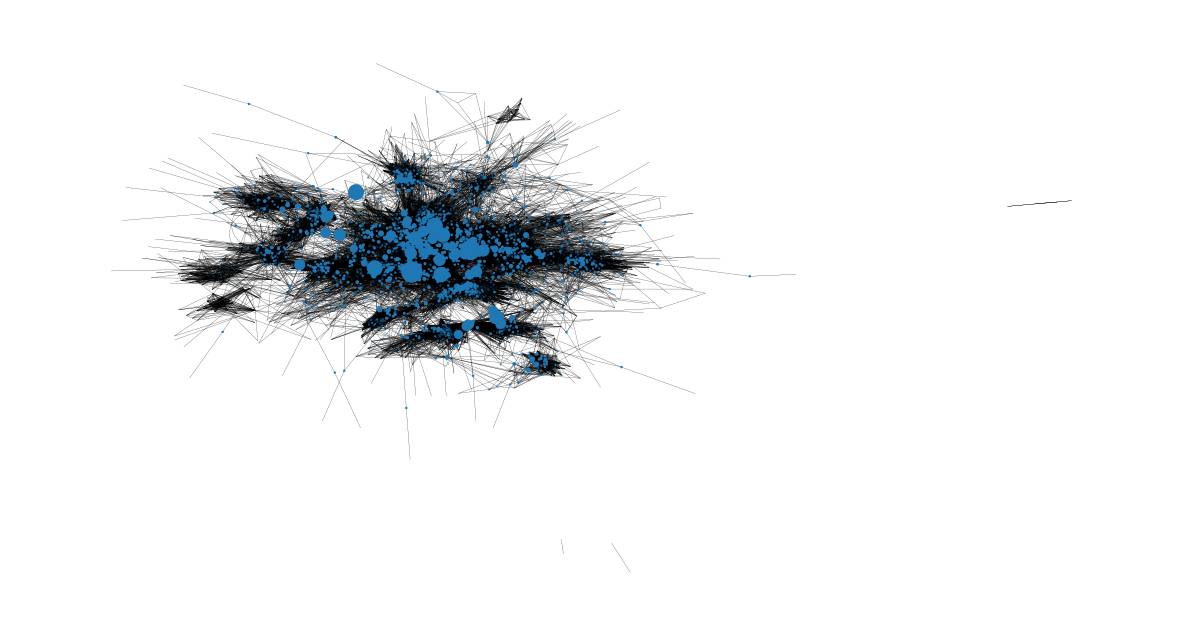

In [43]:
# Visualizar los nodos con mayor centralidad de intermediación
node_size = [v * 1200 for v in betweenness_centrality.values()]
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de cercanía

In [44]:
closeness_centrality = nx.centrality.closeness_centrality(G)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:5]

[(3359851, 0.3174907000782523),
 (15234657, 0.2989200839846593),
 (48485771, 0.2947102540271258),
 (7860742, 0.293730499193259),
 (15666380, 0.2907448655999966)]

In [45]:
1 / closeness_centrality[3359851]

3.149698557323187

Text(0, 0.5, 'Conteo')

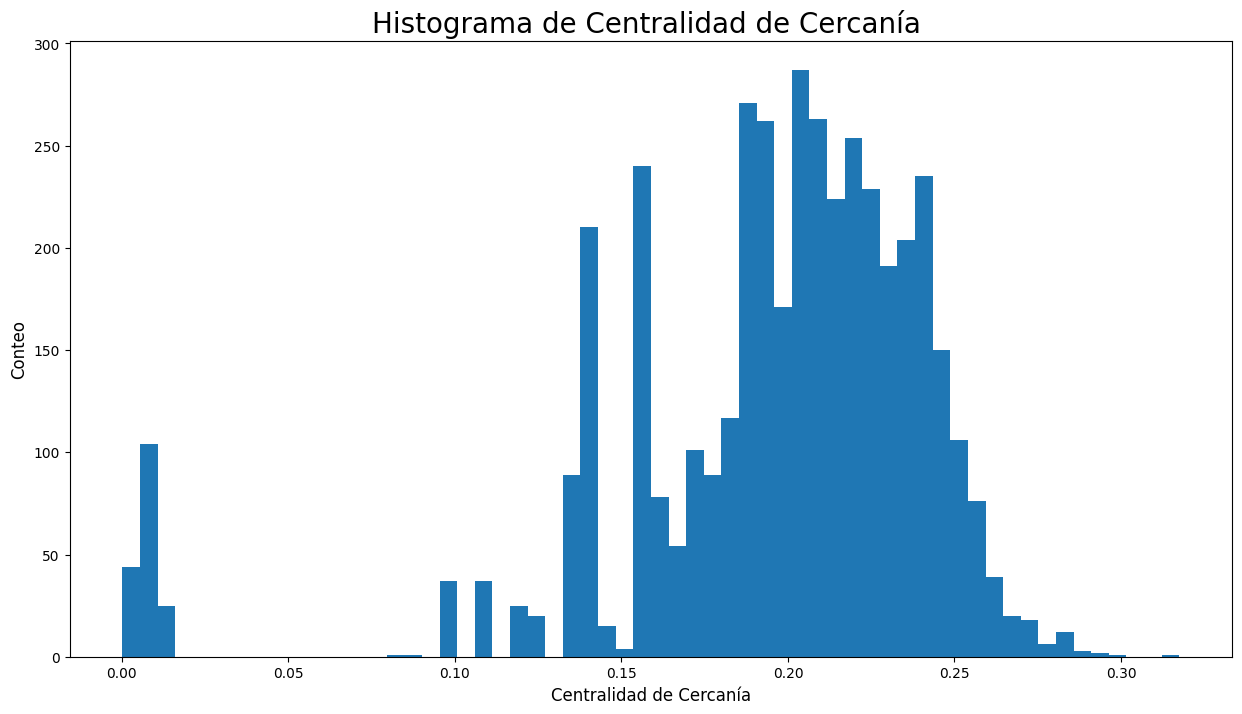

In [46]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Histograma de Centralidad de Cercanía ", fontdict={"size": 20}, loc="center")
plt.xlabel("Centralidad de Cercanía", fontdict={"size": 12})
plt.ylabel("Conteo", fontdict={"size": 12})

La mayoría de nodos tienen un valor menor de 0.3 de centralidad de cercanía. Esto significa que la mayoría de nodos no participan no se encuentran cercanos a los demás. El top 5 identificado logra tener la mayor influencia sobre la red debido a que se encuentran con mayor cercanía al resto de nodos del grafo.

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

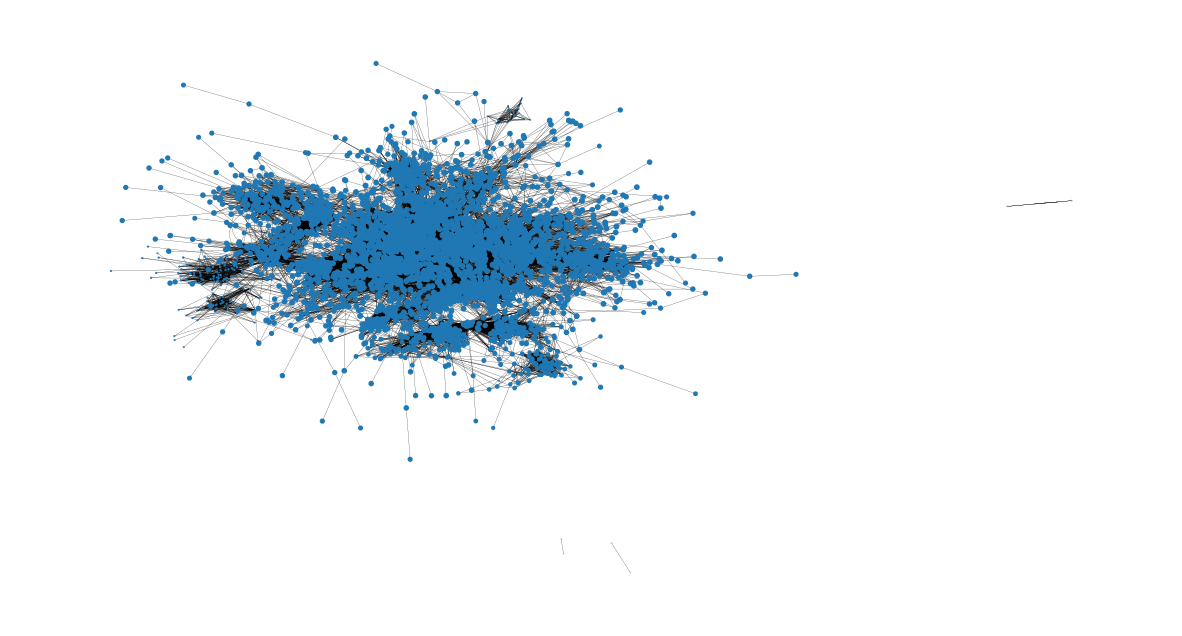

In [47]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de Eigenvector

In [48]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(G)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:5]

[(40981798, 0.15363590744821665),
 (43003845, 0.1507372702636457),
 (22462180, 0.14898138833635383),
 (34428380, 0.14836888505482648),
 (153226312, 0.11747403879993272)]

El nodo 40981798 tiene la centralidad de vector propio más alta con 0.15. Este nodo también es un nodo destacado y seguramente puede considerarse el nodo más importante de esta red en términos de influencia general en toda la red.

In [49]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:5
]  # 2nd to 10th nodes with heighest eigenvector centralities
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]
neighbors_eigen = [n for n in G.neighbors(40981798)]  # list with all nodes connected to
all(
    item in neighbors_eigen for item in high_eigenvector_nodes
)  # check if items in list high_eigenvector_nodes exist in list neighbors

True

Text(0, 0.5, 'Conteo')

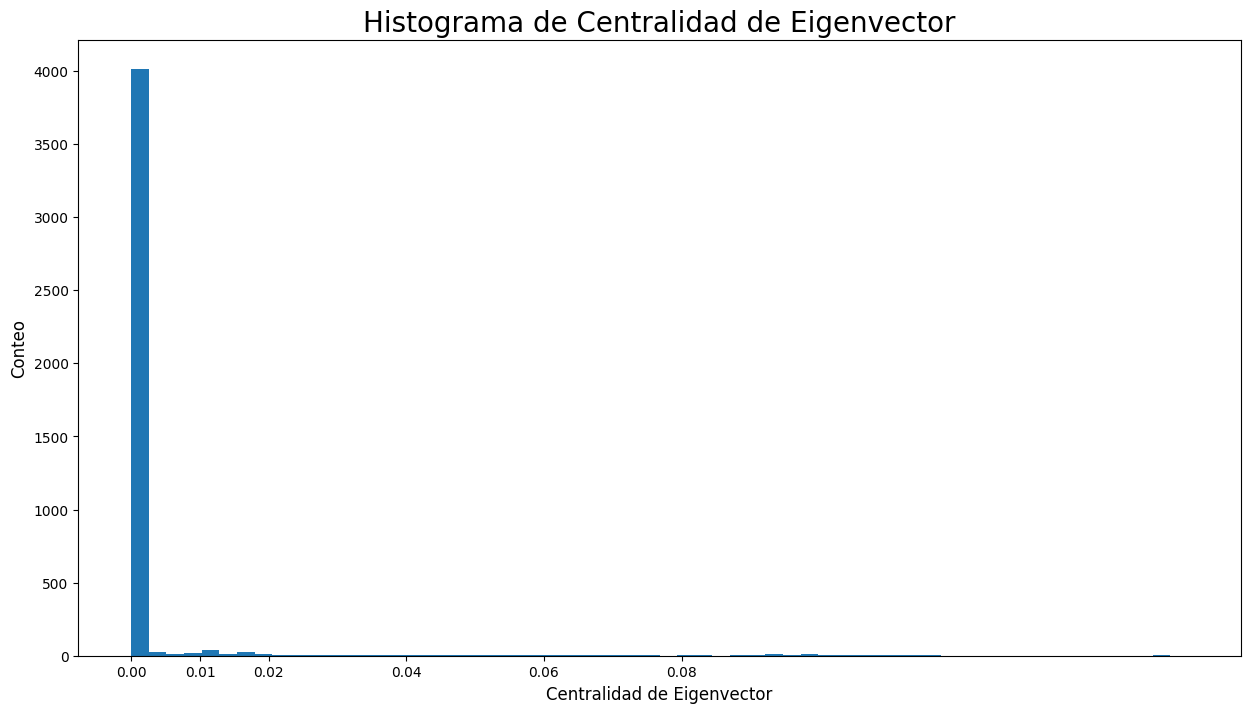

In [50]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title("Histograma de Centralidad de Eigenvector", fontdict={"size": 20}, loc="center")
plt.xlabel("Centralidad de Eigenvector", fontdict={"size": 12})
plt.ylabel("Conteo", fontdict={"size": 12})

(-0.6459461575746537,
 1.1564021235704423,
 -1.0558938056230545,
 0.7013559609651565)

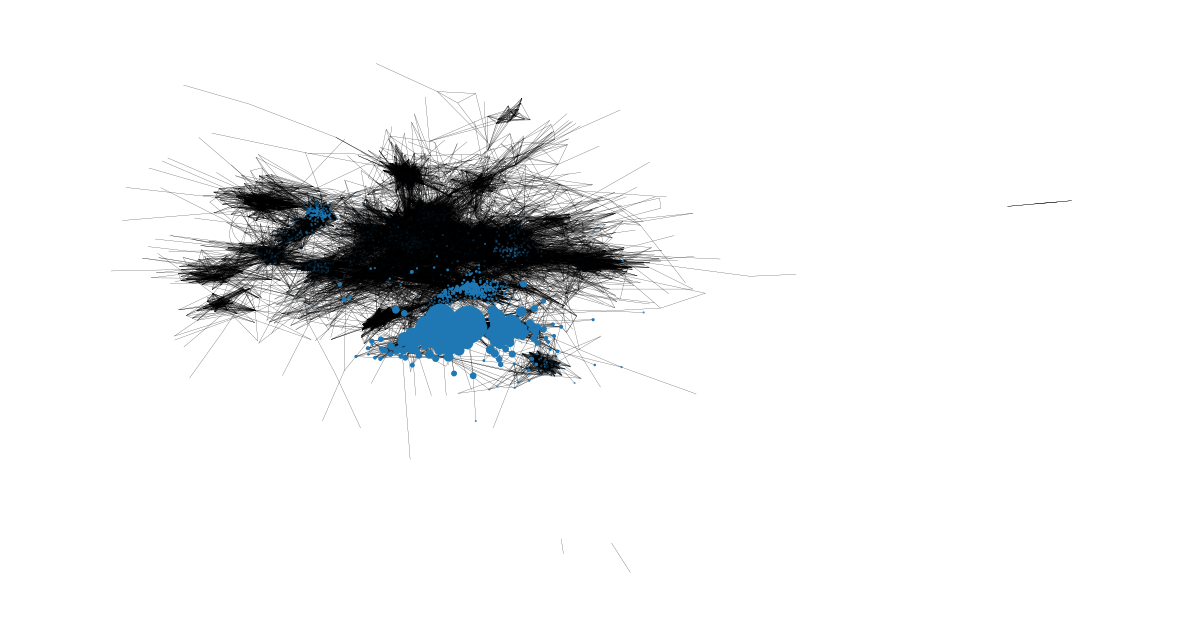

In [51]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

# **Métricas de Resiliencia**

### Asortatividad

In [52]:
nx.degree_assortativity_coefficient(G)

0.07572773506976808

El valor de asortatividad es cercano a 0 por lo que se observa una asortatividad neutral. Esto significa que no hay una preferencia en como se conectan los nodos basado en sus grados.

En nuestro problema de Twitter, observamos que no hay una tendencia específica en que usuarios con el mismo número de seguidores se sigan entre sí.